In [1]:
# Skin Disease Classifier Model with MobileNetV2


In [2]:
pip install albumentations opencv-python tqdm


  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
     ---------------------------------------- 0.0/81.9 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/81.9 kB ? eta -:--:--
     -------------- ----------------------- 30.7/81.9 kB 445.2 kB/s eta 0:00:01
     ------------------ ------------------- 41.0/81.9 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 81.9/81.9 kB 512.1 kB/s eta 0:00:00
     ---------------------------------------- 0.0/72.0 kB ? eta -:--:--
     ---------------------------------------- 72.0/72.0 kB ? eta 0:00:00
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.9 MB 3.6 MB/s eta 0:00:11
   ---------------------------------------- 0.1/38.9 MB 3.6 MB/s eta 0:00


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
from datetime import datetime
import uuid


In [4]:
# Define base path
base_path = "skin_disease_dataset"


In [5]:
# Define augmentations
augmentations = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=20, p=0.5),
    A.RandomGamma(p=0.3),
    A.Blur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
])

c:\Users\iamth\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
# Loop through each folder (class)
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Processing {class_name}: {len(images)} original images")

    for img_name in tqdm(images, desc=f"Augmenting {class_name}"):
        img_path = os.path.join(class_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Create 5 augmentations
        for i in range(5):
            augmented = augmentations(image=image)['image']
            save_name = f"{os.path.splitext(img_name)[0]}_aug{i}_{uuid.uuid4().hex[:6]}.jpg"
            save_path = os.path.join(class_path, save_name)
            cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

print("✅ All folders augmented by 5×.")

Processing acne: 120 original images


Augmenting acne: 100%|██████████| 120/120 [00:00<00:00, 149.92it/s]


Processing eczema: 120 original images


Augmenting eczema: 100%|██████████| 120/120 [00:00<00:00, 164.10it/s]


Processing healthy: 120 original images


Augmenting healthy: 100%|██████████| 120/120 [00:00<00:00, 212.62it/s]


Processing psoriasis: 120 original images


Augmenting psoriasis: 100%|██████████| 120/120 [00:00<00:00, 202.61it/s]


Processing ringworm: 120 original images


Augmenting ringworm: 100%|██████████| 120/120 [00:00<00:00, 166.33it/s]

✅ All folders augmented by 5×.


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os


In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [9]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2
)



In [10]:
train_data = train_datagen.flow_from_directory(
    'skin_disease_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 2880 images belonging to 5 classes.


In [11]:
val_data = train_datagen.flow_from_directory(
    'skin_disease_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 720 images belonging to 5 classes.


In [12]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [13]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


c:\Users\iamth\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 59s 623ms/step - accuracy: 0.2374 - loss: 2.0516 - val_accuracy: 0.3778 - val_loss: 1.4832
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - accuracy: 0.3415 - loss: 1.5958 - val_accuracy: 0.4736 - val_loss: 1.3141
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - accuracy: 0.4229 - loss: 1.4130 - val_accuracy: 0.4958 - val_loss: 1.2359
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.4568 - loss: 1.3327 - val_accuracy: 0.5486 - val_loss: 1.1550
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.5104 - loss: 1.2161 - val_accuracy: 0.5333 - val_loss: 1.1159
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.5247 - loss: 1.1584 - val_accuracy: 0.6000 - val_loss: 1.0382
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - accuracy: 0.5609 - loss: 1.1168 - val_accuracy: 0.6014 - val_loss: 1.0279
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.5528 - loss: 1.1231 - val_accu

In [15]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    """
    Plots training and validation accuracy and loss from a Keras history object.
    """
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


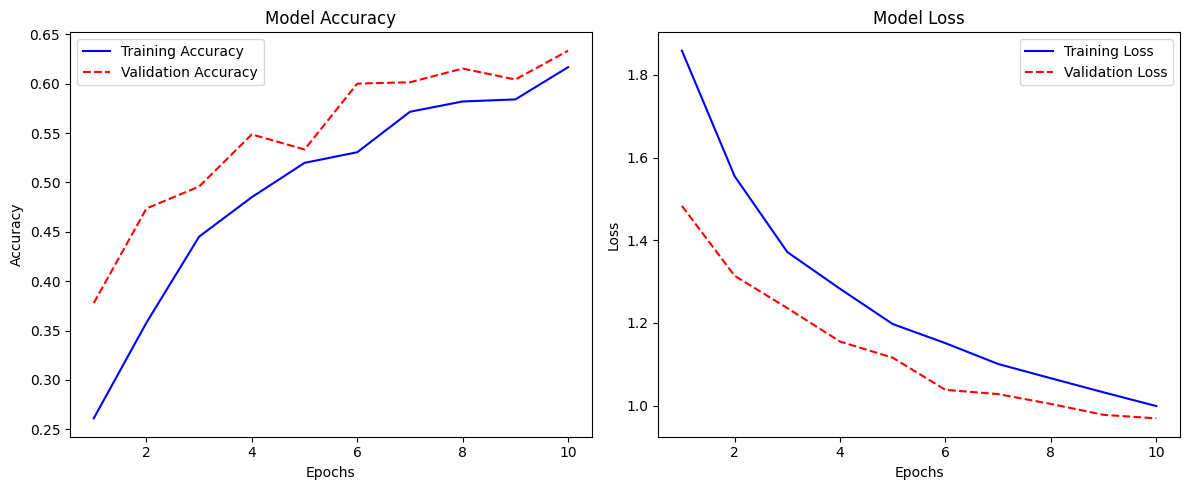

In [16]:
plot_training_metrics(history)


In [ ]:
base_model.trainable = True  # Unfreeze for fine-tuning
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 5
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=total_epochs,
    initial_epoch=10
)
